<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Market_Return_by_Dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:40:38 Starting...
14:40:38 Installing yfinance into Google notebook...
14:40:48 Installing arch into Google notebook...
14:40:59 Initialized.


## Get the Data

In [68]:
data,ticker_name=download(ticker:='SPY',auto_adjust=True).xs(ticker,axis=1,level=1),'S&P 500 Index ETF'
data['Return']=data['Close'].pct_change()*hundred
data.columns.name=ticker_name
data.dropna(inplace=True)
data.index=list(map(lambda x:pd.Period(x,'D'),data.index))
data['Weekday']=list(map(lambda x:x.strftime("%A"),data.index))
data['Monthday']=data.index.day
data['DaysInMonth']=list(map(lambda x:pd.Period(x,'M').daysinmonth,data.index))
data['Month']=list(map(lambda x:x.strftime("%B"),data.index))
display(data)

[*********************100%***********************]  1 of 1 completed


S&P 500 Index ETF,Close,High,Low,Open,Volume,Return,Weekday,Monthday,DaysInMonth,Month
1993-02-01,24.626432,24.626432,24.469908,24.469908,480500,0.711216,Monday,1,28,February
1993-02-02,24.678610,24.696001,24.556869,24.609044,201300,0.211876,Tuesday,2,28,February
1993-02-03,24.939493,24.956885,24.696011,24.713403,529400,1.057123,Wednesday,3,28,February
1993-02-04,25.043833,25.096007,24.748176,25.026441,531500,0.418371,Thursday,4,28,February
1993-02-05,25.026447,25.078622,24.887315,25.026447,492100,-0.069420,Friday,5,28,February
...,...,...,...,...,...,...,...,...,...,...
2025-04-10,524.580017,533.500000,509.320007,532.169983,162331200,-4.381900,Thursday,10,30,April
2025-04-11,533.940002,536.429993,520.070007,523.010010,97866300,1.784282,Friday,11,30,April
2025-04-14,539.119995,544.280029,533.859985,544.049988,68034000,0.970145,Monday,14,30,April
2025-04-15,537.609985,543.229980,536.809998,539.669983,56628300,-0.280088,Tuesday,15,30,April


## Analyse Returns by Day of the Week
### First Just a Simple Grouped Mean

16:47:59 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value
Day of Week,,,,,,
Monday,0.047249,1.292804,1523,0.033127,1.426299,0.153987
Tuesday,0.071263,1.173253,1665,0.028753,2.478436,0.013294
Wednesday,0.057775,1.147243,1663,0.028133,2.053667,0.040164
Thursday,0.014281,1.180170,1633,0.029205,0.488993,0.624912
Friday,0.033504,1.110541,1625,0.027549,1.216159,0.224101


16:47:59 Wrote plot to Average Returns of S&P 500 Index ETF by Day of the Week.png.
16:47:59 One Way ANOVA Analysis by Day of the Week


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,3.183235,4.0,0.570844,0.683805,
Within Groups,11297.718608,8104.0,,,


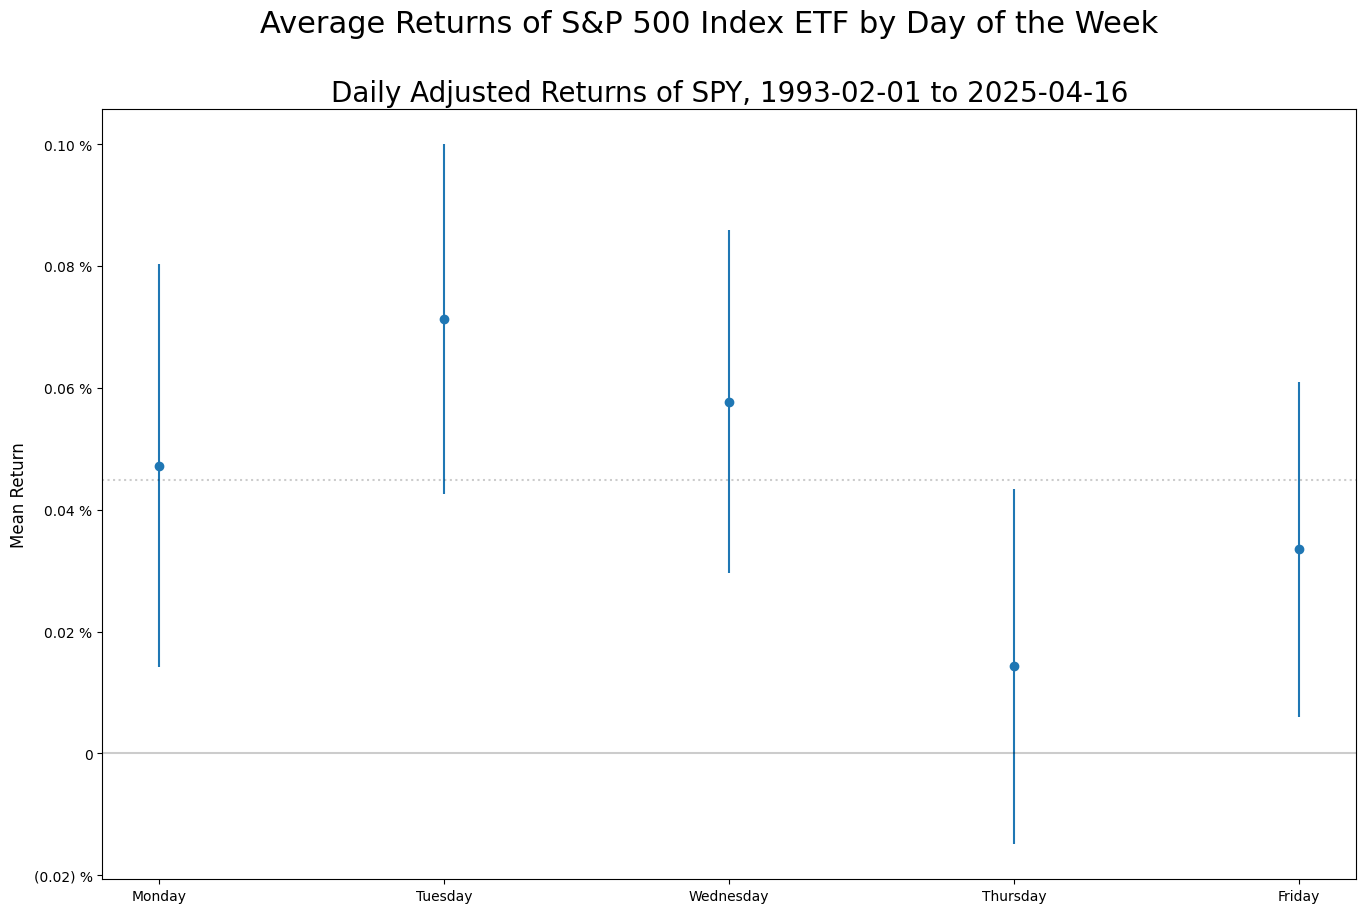

In [92]:
from scipy.stats import t as studentt
from statsmodels.formula.api import ols as OLSformula
from statsmodels.stats.anova import anova_lm

nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return','Weekday']].groupby("Weekday")).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results.index.name='Day of Week'
results=results.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday'])
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_name:="Day of the Week"),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

nprint("One Way ANOVA Analysis by {}".format(group_name))
fit=OLSformula("Return ~ Weekday",data).fit()
anova=anova_lm(fit,typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

### Now do an OLS with Indicator Variables
This will deliver *exactly* the same results as the grouped means, but with some other statistics for "free."

In [93]:
from statsmodels.regression.linear_model import OLS

nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data['Weekday'],columns=['Weekday'],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

16:48:00 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,Monday,Tuesday,Wednesday,Thursday,Friday,Return
1993-02-01,1.0,0.0,0.0,0.0,0.0,0.711216
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.211876
1993-02-03,0.0,0.0,1.0,0.0,0.0,1.057123
1993-02-04,0.0,0.0,0.0,1.0,0.0,0.418371
1993-02-05,0.0,0.0,0.0,0.0,1.0,-0.069420
...,...,...,...,...,...,...
2025-04-10,0.0,0.0,0.0,1.0,0.0,-4.381900
2025-04-11,0.0,0.0,0.0,0.0,1.0,1.784282
2025-04-14,1.0,0.0,0.0,0.0,0.0,0.970145
2025-04-15,0.0,1.0,0.0,0.0,0.0,-0.280088


16:48:00                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5708
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.684
Time:                        16:48:00   Log-Likelihood:                -12851.
No. Observations:                8109   AIC:                         2.571e+04
Df Residuals:                    8104   BIC:                         2.575e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.0472      0.030      1.562

### Now fit a GJR-GARCH(1,1,1) Model with the Same Dummies and Non-Normal Innovations
This is a _way more accurate_ distributional model that the Normal model assumed by OLS. It will weight high-volatility days appropriately.

16:51:21 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10678.304180442607
            Iterations: 27
            Function evaluations: 541
            Gradient evaluations: 27
16:51:22                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -10678.3
Distribution:      Generalized Error Distribution   AIC:                           21390.6
Method:                        Maximum Likelihood   BIC:                           21509.6
                                                    No. Observations:                 8109
Date:                            Wed, Apr 16 2025   Df Residuals:                 

,Estimate,Std.Err.,Null Value,t Score,p Value
January,0.096310,0.027327,0.0,3.524382,0.000424
February,0.085528,0.020441,0.0,4.184116,0.000029
March,0.039711,0.028839,0.0,1.377006,0.16851
April,0.062917,0.023699,0.0,2.654809,0.007935
May,0.035913,0.026231,0.0,1.369105,0.170967
June,0.043382,0.028696,0.0,1.511749,0.130598
July,0.066882,0.022140,0.0,3.020862,0.002521
August,0.044134,0.023459,0.0,1.881297,0.059931
September,0.008668,0.025382,0.0,0.34151,0.73272
October,0.070048,0.023678,0.0,2.958336,0.003093


16:51:23 Wrote plot to Effect of Volatilty on Estimated Returns of S&P 500 Index ETF by Day of the Week.png.


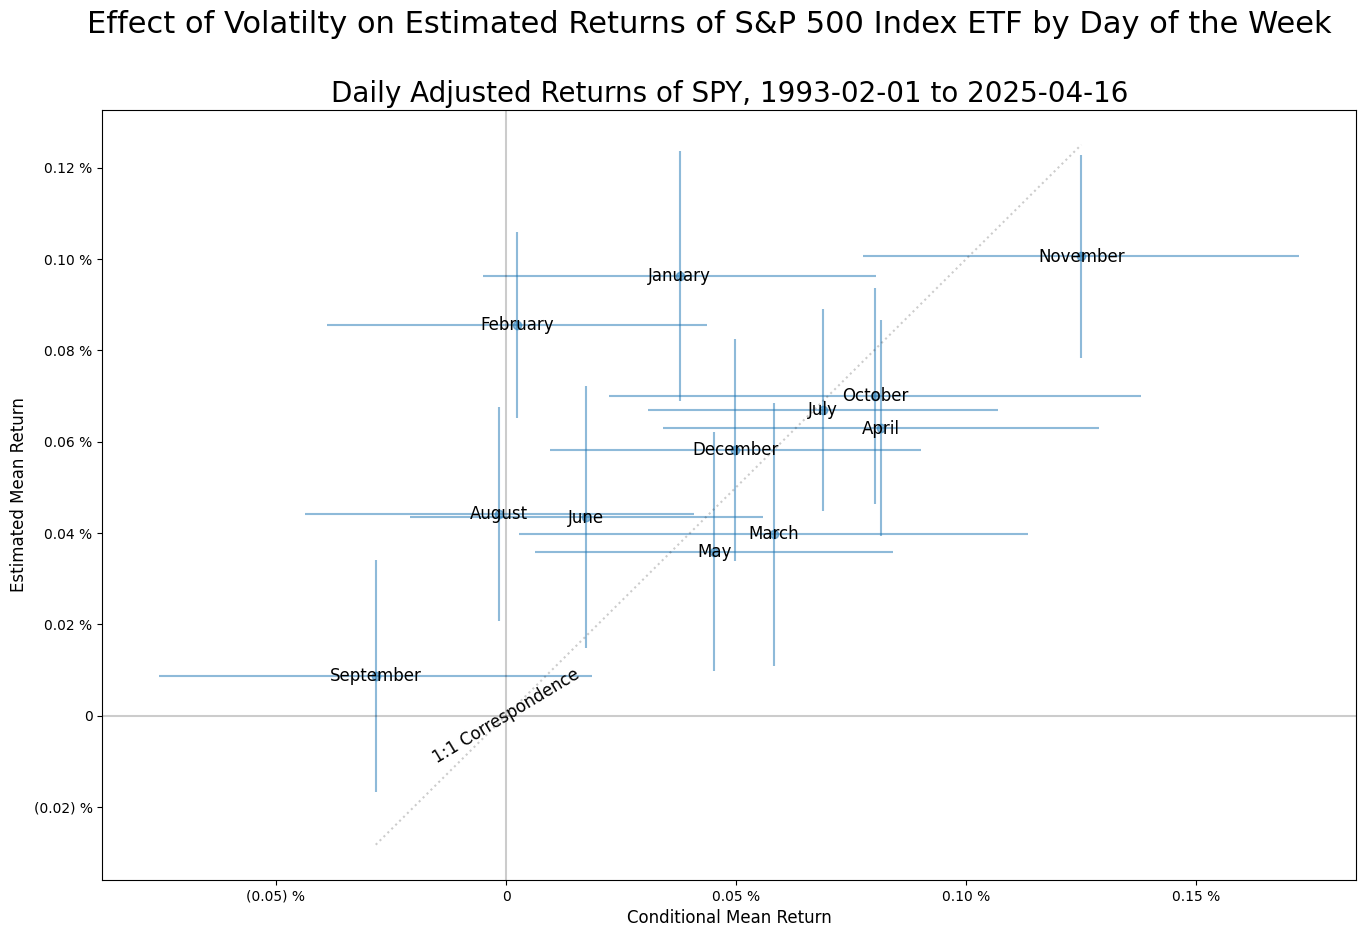

In [100]:
from scipy.stats import norm

nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan]*4+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
display(results.replace(np.nan,""))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(xx:=y,yy:=results.loc[x,'Estimate'],xerr=ye,yerr=results.loc[x,'Std.Err.'],fmt='o',alpha=0.5)

for day in x:
  plot.text(xx.loc[day],yy.loc[day],day,ha='center',va='center',fontsize=12)

plot.plot(r:=[min([-0.02,xx.min(),yy.min()]),max([0.1,xx.max(),yy.max()])],r,':',color='black',alpha=0.2)
plot.text(zero,zero,'1:1 Correspondence',fontsize=12,ha='center',va='center',rotation=31)
plot.axhline(color='black',alpha=0.2)
plot.axvline(color='black',alpha=0.2)
plot.set_xlabel("Conditional Mean Return",fontsize=12)
plot.set_ylabel("Estimated Mean Return",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(2))
plot.yaxis.set_major_formatter(PercentLabels(2))
figure.suptitle(title:="Effect of Volatilty on Estimated Returns of {} by {}".format(ticker_name,group_name:="Day of the Week"),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### Repeat the Simple Plot by Day of Week

16:48:03 Wrote plot to Estimated Mean Returns of S&P 500 Index ETF by Day of the Week.png.


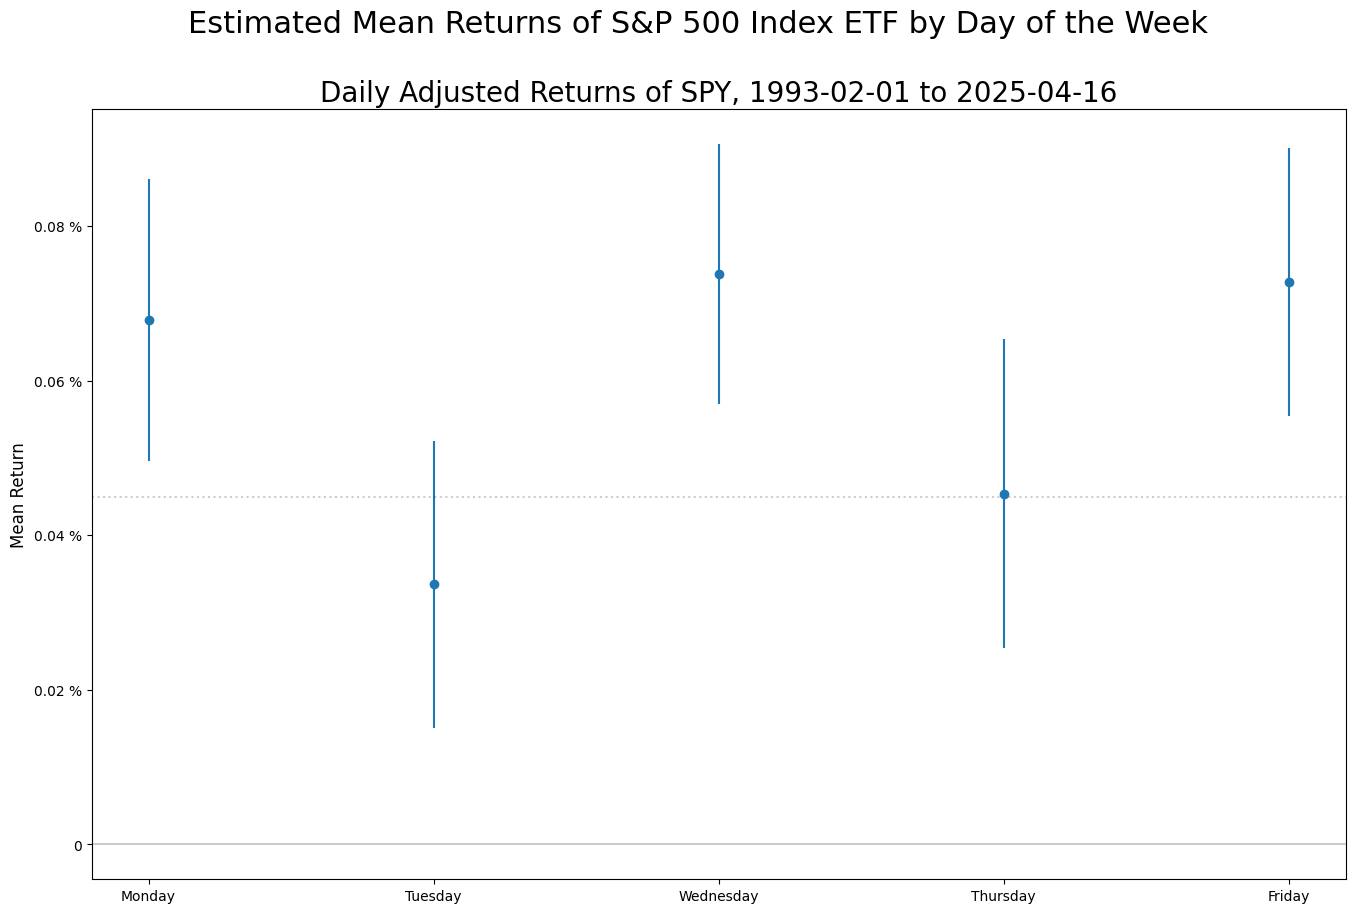

In [95]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x,results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Estimated Mean Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

## Now Look at Calendar Months
### First Compute the Simple Grouped Means Again

16:48:03 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value
Month,,,,,,
January,0.037709,1.089757,652,0.042678,0.883568,0.377256
February,0.002342,1.039071,633,0.041299,0.056719,0.954787
March,0.058151,1.488191,723,0.055346,1.050677,0.293758
April,0.081497,1.229588,672,0.047432,1.718172,0.086227
May,0.045211,1.010229,677,0.038826,1.164454,0.244651
June,0.017389,1.001430,682,0.038347,0.453470,0.650355
July,0.068893,0.989764,675,0.038096,1.808401,0.070990
August,-0.001473,1.125582,710,0.042242,-0.034875,0.972190
September,-0.028300,1.199233,650,0.047038,-0.601646,0.547620


16:48:04 Wrote plot to Average Returns of S&P 500 Index ETF by Month.png.
16:48:04 One Way ANOVA Analysis by Month


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,3.183235,4.0,0.570844,0.683805,
Within Groups,11297.718608,8104.0,,,


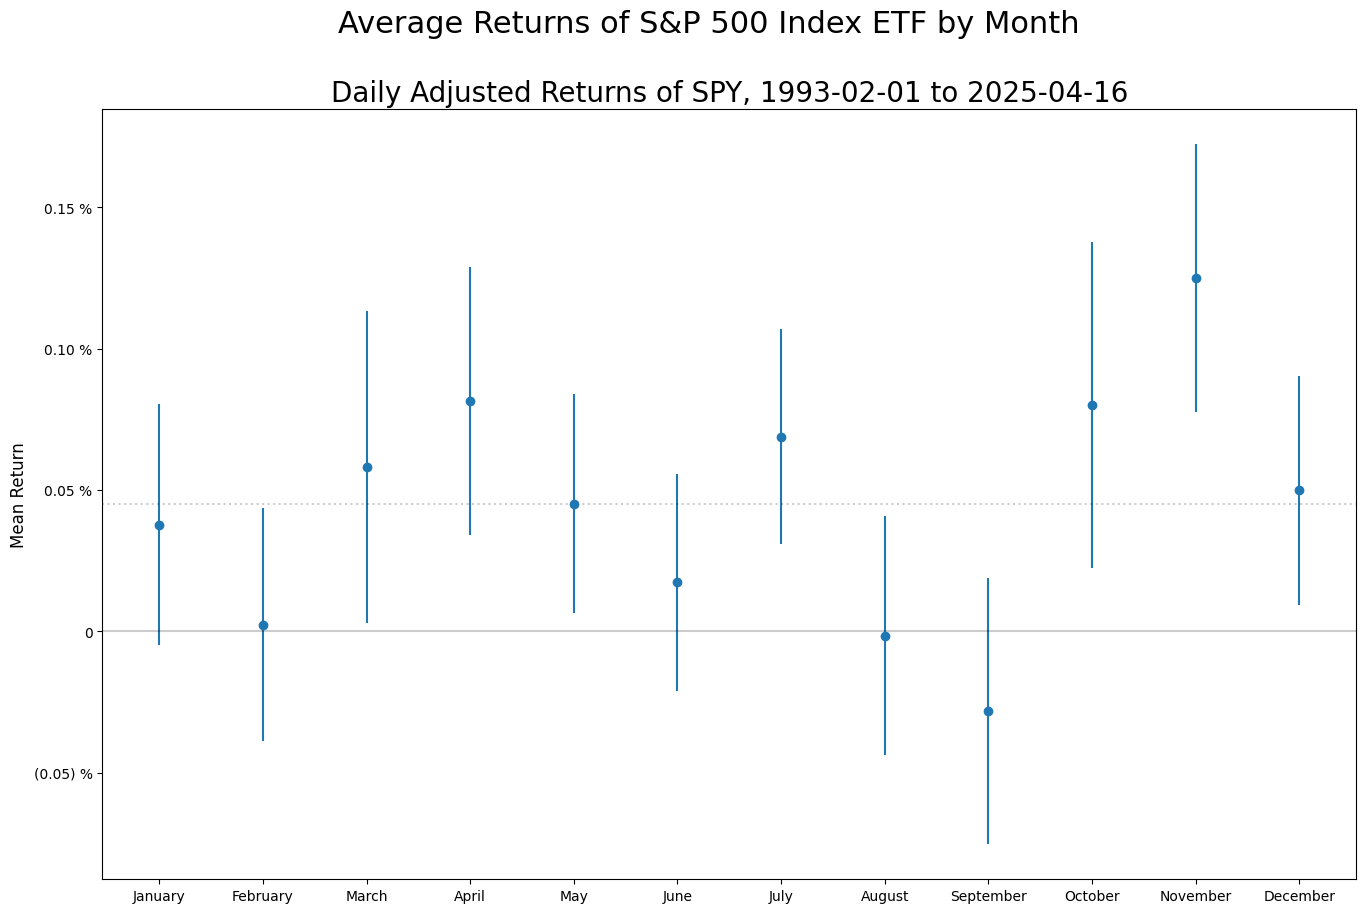

In [96]:
nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return',group_name:='Month']].groupby(group_name)).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results.index.name=group_name
results=results.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

nprint("One Way ANOVA Analysis by {}".format(group_name))
fit=OLSformula("Return ~ Weekday",data).fit()
anova=anova_lm(fit,typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

### Then the OLS with Indicator Variables

In [97]:
nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data['Month'],columns=['Month'],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

16:48:05 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,January,February,March,April,May,June,July,August,September,October,November,December,Return
1993-02-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711216
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211876
1993-02-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.057123
1993-02-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418371
1993-02-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.069420
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.381900
2025-04-11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.784282
2025-04-14,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.970145
2025-04-15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.280088


16:48:05                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8620
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.577
Time:                        16:48:05   Log-Likelihood:                -12847.
No. Observations:                8109   AIC:                         2.572e+04
Df Residuals:                    8097   BIC:                         2.580e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
January        0.0377      0.046      0.816

### Finally fit the GJR-GARCH(1,1,1) Model

16:51:51 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10678.304180442607
            Iterations: 27
            Function evaluations: 541
            Gradient evaluations: 27
16:51:53                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -10678.3
Distribution:      Generalized Error Distribution   AIC:                           21390.6
Method:                        Maximum Likelihood   BIC:                           21509.6
                                                    No. Observations:                 8109
Date:                            Wed, Apr 16 2025   Df Residuals:                 

,Estimate,Std.Err.,Null Value,t Score,p Value
January,0.096310,0.027327,0.0,3.524382,0.000424
February,0.085528,0.020441,0.0,4.184116,0.000029
March,0.039711,0.028839,0.0,1.377006,0.16851
April,0.062917,0.023699,0.0,2.654809,0.007935
May,0.035913,0.026231,0.0,1.369105,0.170967
June,0.043382,0.028696,0.0,1.511749,0.130598
July,0.066882,0.022140,0.0,3.020862,0.002521
August,0.044134,0.023459,0.0,1.881297,0.059931
September,0.008668,0.025382,0.0,0.34151,0.73272
October,0.070048,0.023678,0.0,2.958336,0.003093


16:51:54 Wrote plot to Effect of Volatility on Estimated Returns of S&P 500 Index ETF by Day of the Week.png.


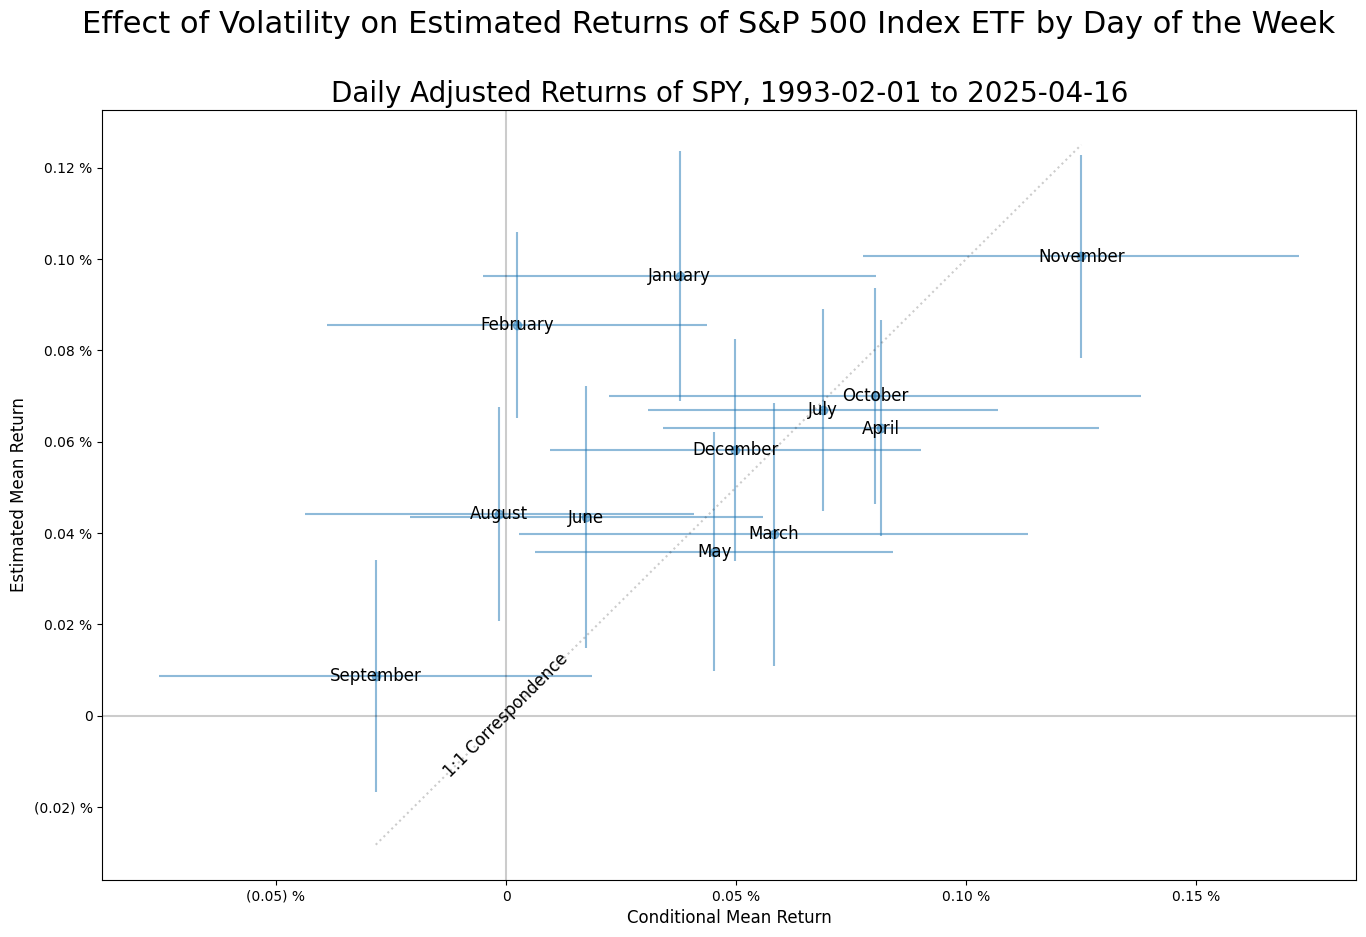

In [101]:
nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan]*4+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
display(results.replace(np.nan,""))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(xx:=y,yy:=results.loc[x,'Estimate'],xerr=ye,yerr=results.loc[x,'Std.Err.'],fmt='o',alpha=0.5)

for day in x:
  plot.text(xx.loc[day],yy.loc[day],day,ha='center',va='center',fontsize=12)

plot.plot(r:=[min([-0.02,xx.min(),yy.min()]),max([0.1,xx.max(),yy.max()])],r,':',color='black',alpha=0.2)
plot.text(zero,zero,'1:1 Correspondence',fontsize=12,ha='center',va='center',rotation=45)
plot.axhline(color='black',alpha=0.2)
plot.axvline(color='black',alpha=0.2)
plot.set_xlabel("Conditional Mean Return",fontsize=12)
plot.set_ylabel("Estimated Mean Return",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(2))
plot.yaxis.set_major_formatter(PercentLabels(2))
figure.suptitle(title:="Effect of Volatility on Estimated Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### Repeat the Simple Plot by Month

16:50:06 Wrote plot to Estimated Mean Returns of S&P 500 Index ETF by Month.png.


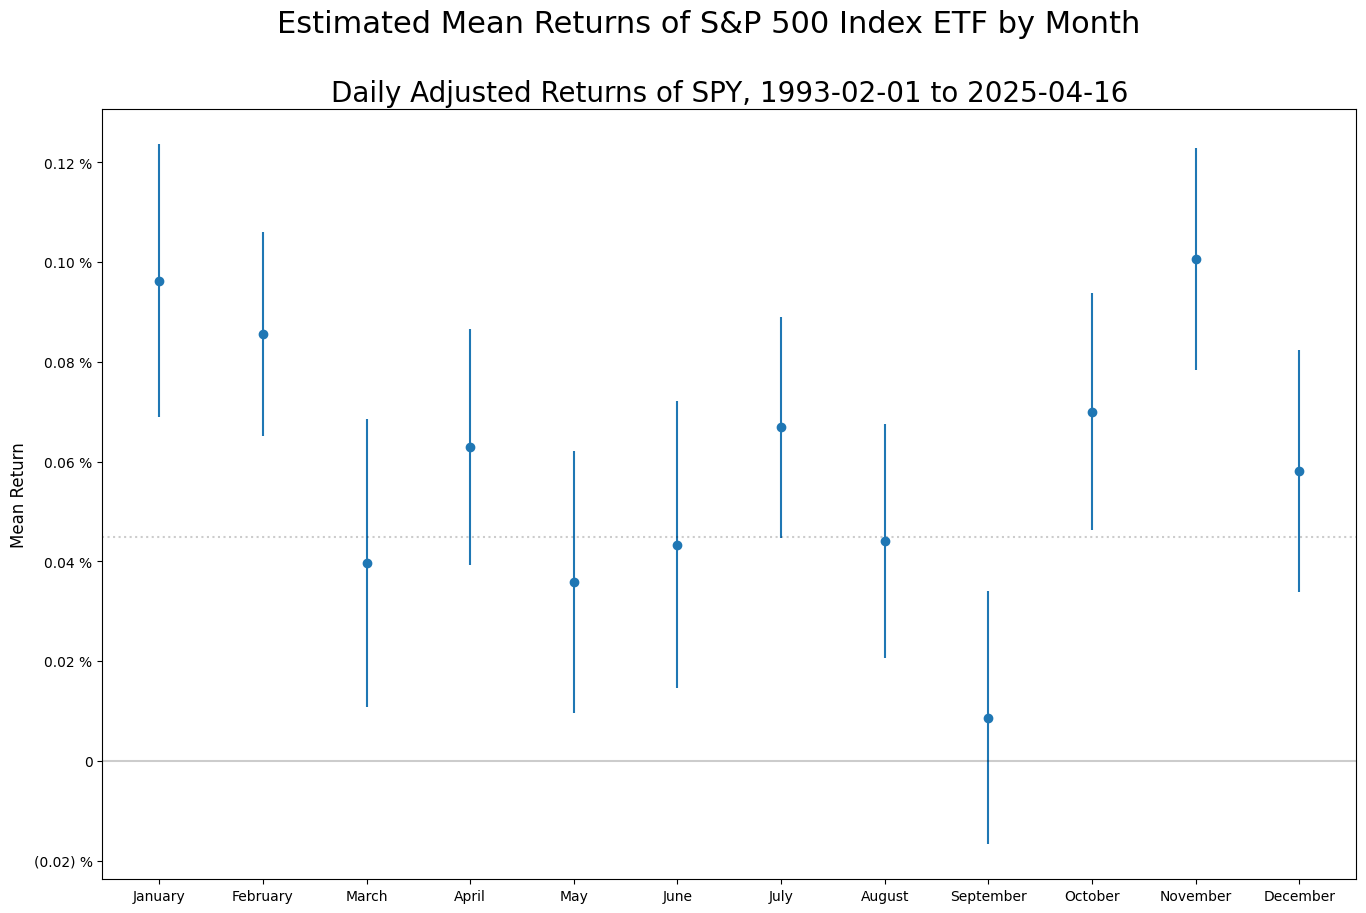

In [99]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x,results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Estimated Mean Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))